### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [1]:
# Imports
import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta as td
import sklearn.metrics
from sklearn.model_selection import train_test_split, PredefinedSplit, StratifiedShuffleSplit
from autosklearn.pipeline.components.classification import add_classifier
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc, average_precision
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import import_dataset, add_pyod_models_to_pipeline, balanced_split, get_metric_result
# Add models to Auto-Sklearn
add_pyod_models_to_pipeline()

In [5]:
# Sample number
N = 5000
# Datasets
datasets = [
    '../../data/Cardiotocography_withoutdupl_norm_02_v10.arff',
    '../../data/Cardiotocography_withoutdupl_norm_05_v10.arff',
    '../../data/Cardiotocography_withoutdupl_norm_10_v10.arff',
    '../../data/Cardiotocography_withoutdupl_norm_20_v10.arff',
    '../../data/Cardiotocography_withoutdupl_norm_22.arff'
]
# Test performance dict
test_performance = {}

# Loop
for dataset in datasets:
    print('Dataset:', dataset)
    # Import DataFrame
    df = import_dataset(dataset)
    if(len(df) > N):
        df = df.sample(n=N)
    # Extract X, y
    X  = df.iloc[:, :-1]
    y = df['outlier']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)
    
    # Method 1 - Custom split
    #selected_indices = balanced_split(y_train)
    #resampling_strategy = PredefinedSplit(test_fold=selected_indices)

    # Method 2 - Stratified Shuffle Split
    resampling_strategy = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

    # Build and fit a classifier
    automl = AutoSklearnClassifier(
        include = {
          'classifier': [
              #'ABODClassifier',
              'CBLOFClassifier',
              'COPODClassifier',
              'ECODClassifier',
              'HBOSClassifier',
              'IForestClassifier',
              'KNNClassifier',
              #'LMDDClassifier',
              'LOFClassifier',
              'MCDClassifier',
              'OCSVMClassifier',
              'PCAClassifier',
              #'RODClassifier',
              'SOSClassifier'
          ],
          'feature_preprocessor': ["no_preprocessing"],
        },
        exclude = None,
        metric = roc_auc,
        scoring_functions = [roc_auc, average_precision],
        time_left_for_this_task = 120,
        per_run_time_limit = 30,
        ensemble_size = 0,
        initial_configurations_via_metalearning = 0,
        resampling_strategy = resampling_strategy,
    )
    # Fit
    print('Fitting..')
    automl.fit(X_train, y_train, X_test, y_test, dataset_name='Cardiography')

    # Print stats
    print(automl.sprint_statistics())
    #print(get_metric_result(automl.cv_results_).to_string(index=False))
    # Store test set performance
    test_performance[dataset] = automl.performance_over_time_[['Timestamp', 'single_best_test_score']]

Dataset: ../../data/Cardiotocography_withoutdupl_norm_02_v10.arff
Fitting..
[WARNING] [2022-02-24 09:55:13,504:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_d7212a71-9546-11ec-8371-c8d9d2ea2351/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Cardiography
  Metric: roc_auc
  Best validation score: 0.852604
  Number of target algorithm runs: 12
  Number of successful target algorithm runs: 11
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0

Dataset: ../../data/Cardiotocography_withoutdupl_norm_05_v10.arff
Fitting..
[WARNING] [2022-02-24 09:57:10,229:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_1c0c1c16-9547-11ec-8371-c8d9d2ea2351/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Cardiography
  Metric: roc_auc
  Best validation sco

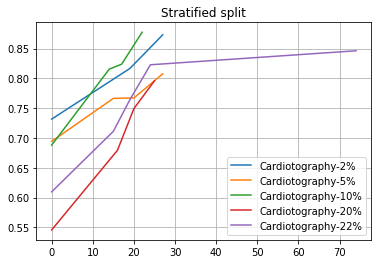

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot test performance
for d, results in test_performance.items():
    plt.plot((results.Timestamp-results.Timestamp[0]).apply(td.total_seconds), results.single_best_test_score)
plt.legend([
    'Cardiotography-2%',
    'Cardiotography-5%',
    'Cardiotography-10%',
    'Cardiotography-20%',
    'Cardiotography-22%'
])
plt.title('Stratified split')
plt.grid()
#plt.savefig('cardiography-stratified.png')
plt.show()